In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html


In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Simulated data

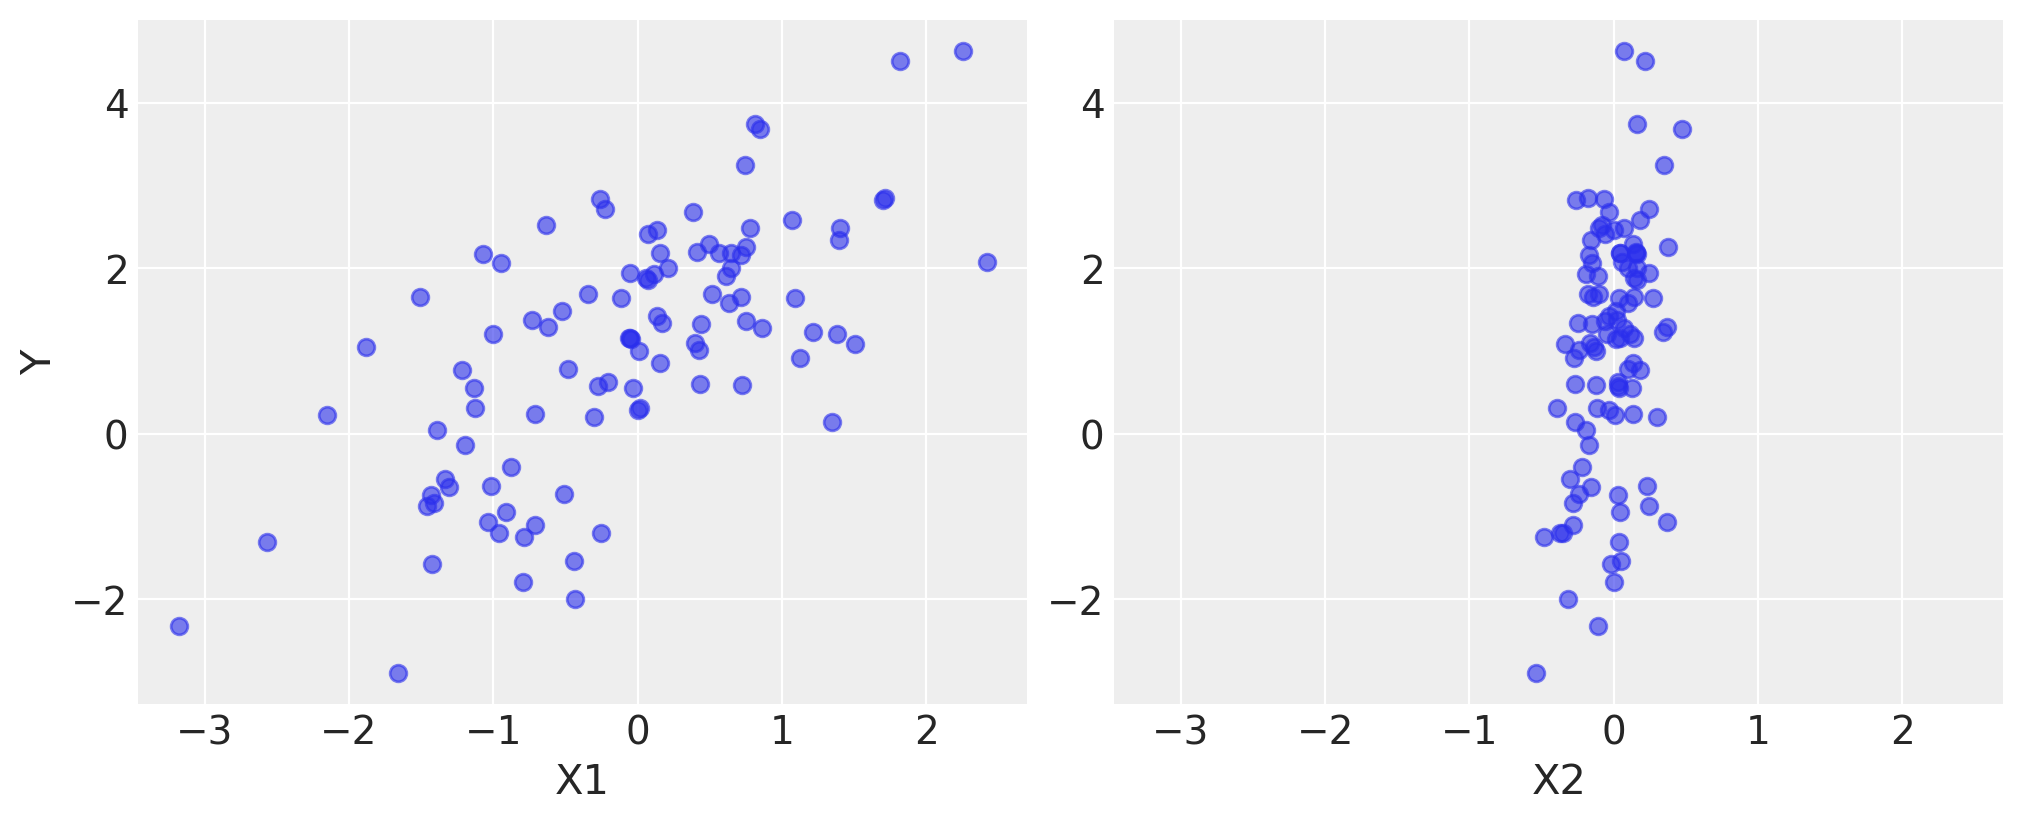

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [5]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.4


In [6]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [7]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [8]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.12065597, 1.159094  , 1.12666278, 1.12666278, 1.24176195],
       [1.10576224, 1.11841313, 1.18603525, 1.17645495, 1.15654894],
       [1.11724718, 1.25107689, 1.03775747, 1.3405746 , 1.30872677],
       [1.18039348, 1.08202878, 0.97457329, 1.01008313, 1.27624021]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

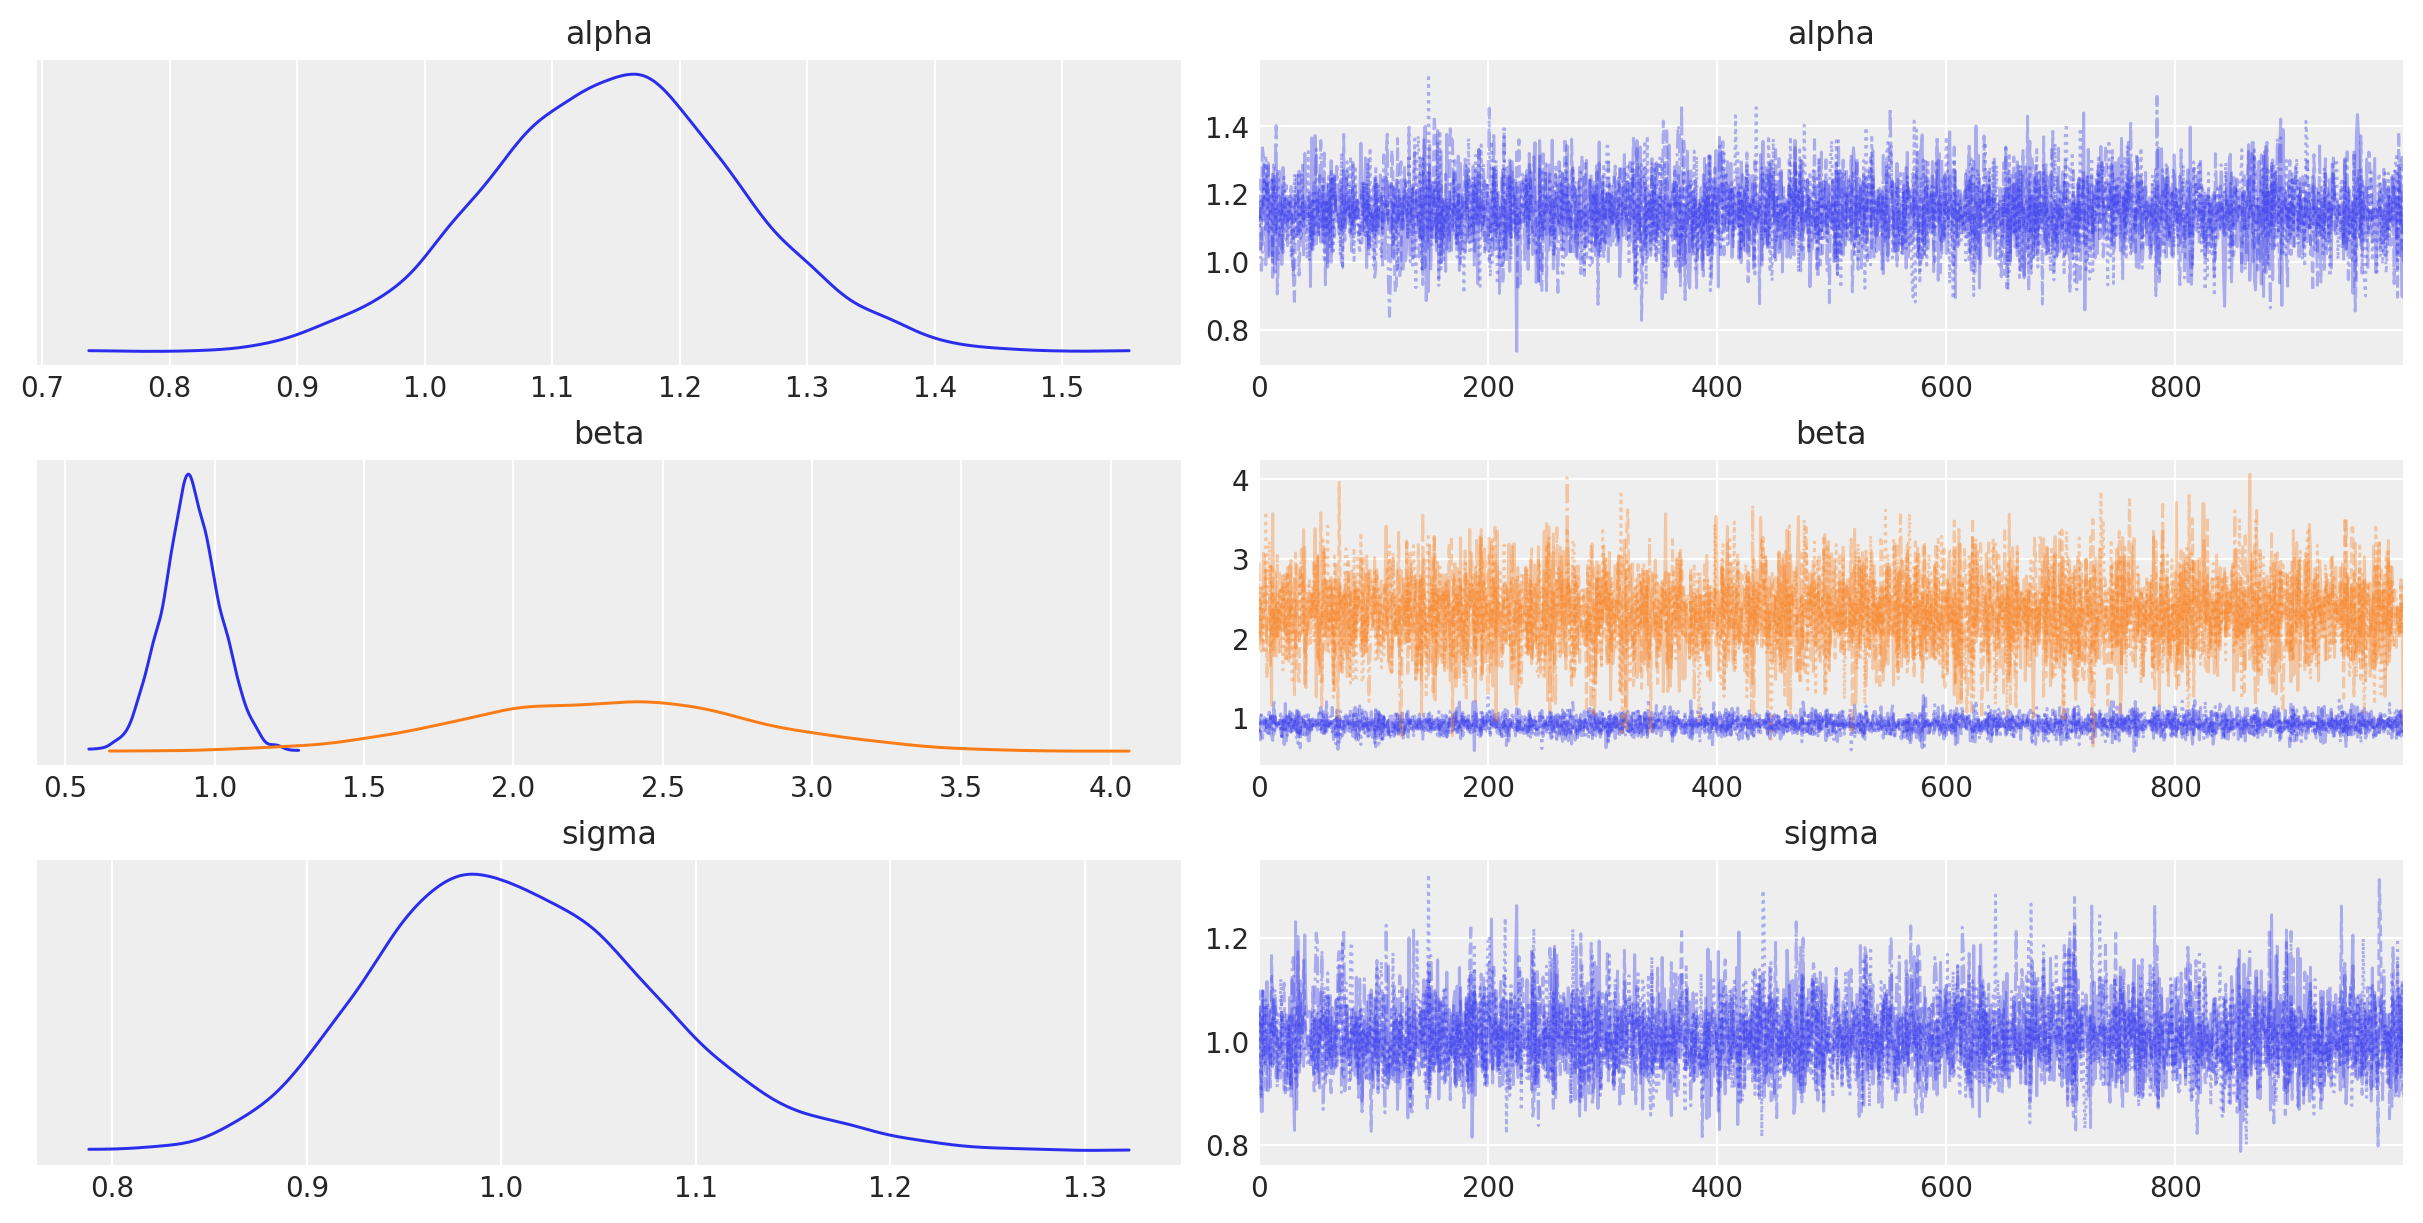

In [9]:
az.plot_trace(idata, combined=True);

In [10]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.15,0.10,0.96,1.34,0.00,0.0,6071.19,3172.64,1.0
beta[0],0.92,0.10,0.73,1.10,0.00,0.0,5688.98,3320.59,1.0
beta[1],2.31,0.49,1.43,3.26,0.01,0.0,5882.59,3240.76,1.0
sigma,1.01,0.07,0.88,1.15,0.00,0.0,5449.76,2858.51,1.0


## Bambi

In [12]:
import bambi as bmb

In [13]:
data = pd.DataFrame({'Y':Y,'X1':X1,'X2':X2})

In [14]:
model = bmb.Model('Y ~ X1 + X2', data)

In [15]:
model

Formula: Y ~ X1 + X2
Family name: Gaussian
Link: identity
Observations: 100
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 1.0403, sigma: 3.7231)
    X1 ~ Normal(mu: 0.0, sigma: 3.5954)
    X2 ~ Normal(mu: 0.0, sigma: 18.2769)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.4804)

In [16]:
result = model.fit(draws=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, X1, X2, Y_sigma]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'X1'}>,
        <AxesSubplot:title={'center':'X1'}>],
       [<AxesSubplot:title={'center':'X2'}>,
        <AxesSubplot:title={'center':'X2'}>],
       [<AxesSubplot:title={'center':'Y_sigma'}>,
        <AxesSubplot:title={'center':'Y_sigma'}>]], dtype=object)

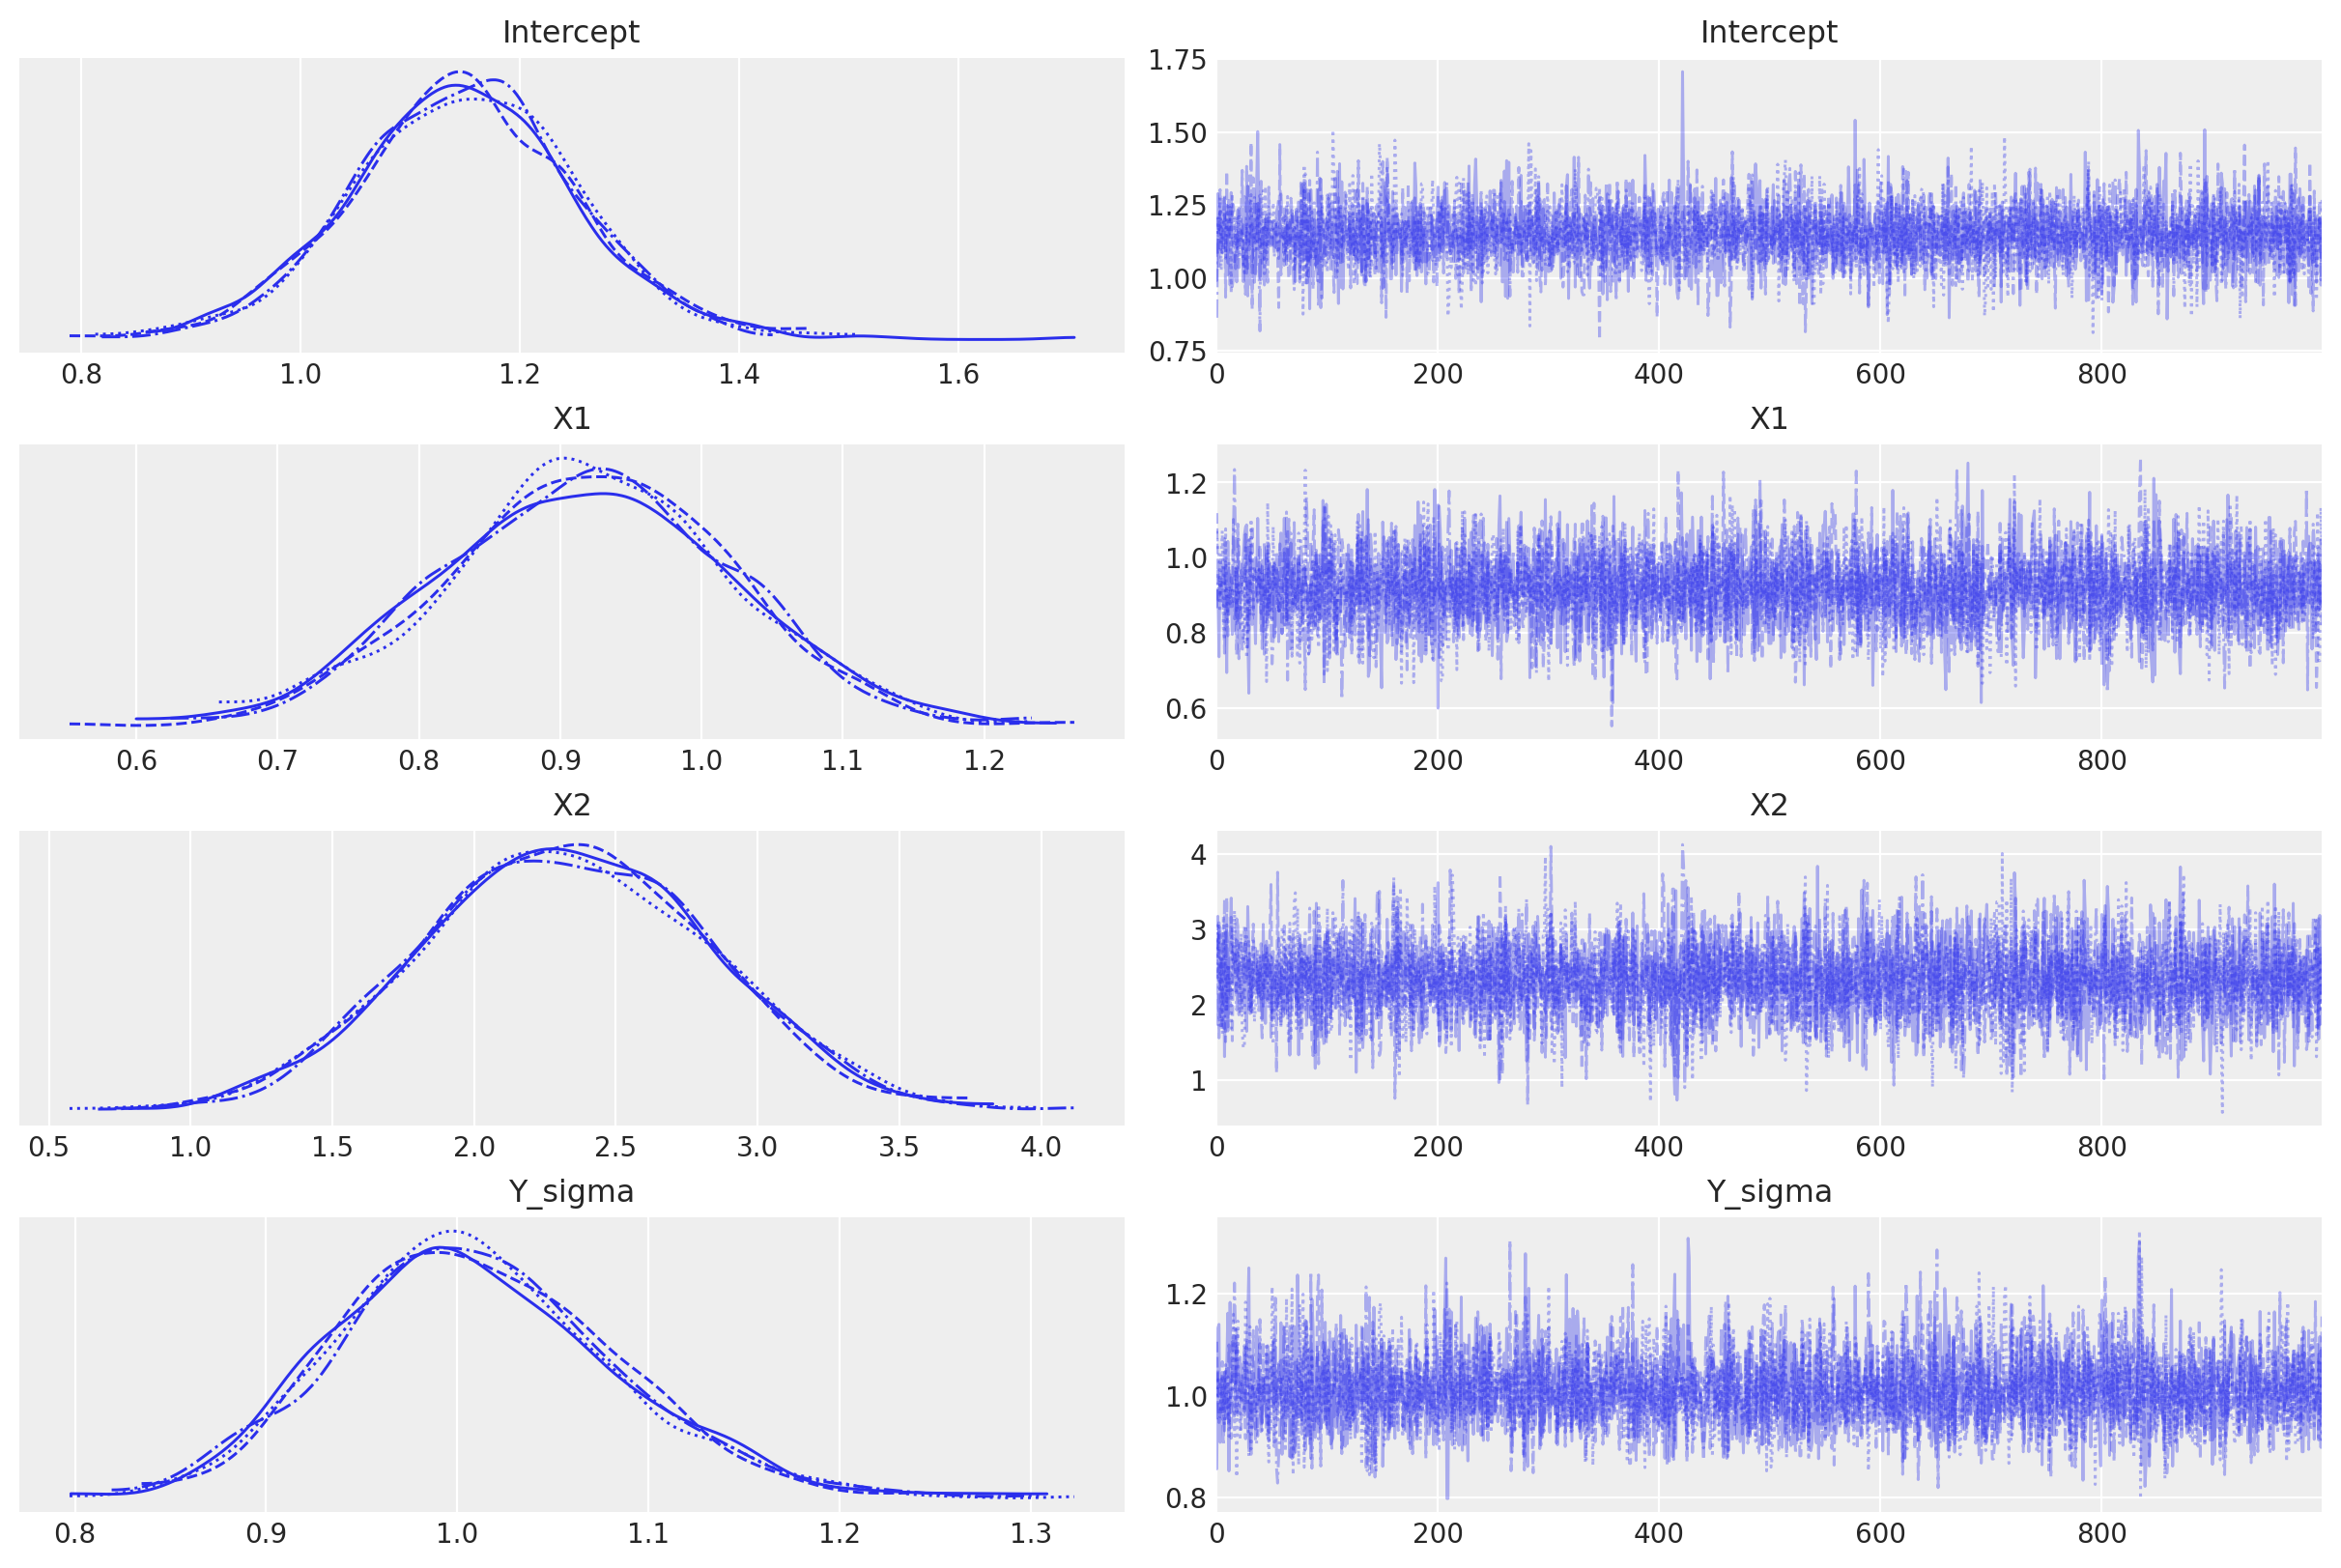

In [17]:
az.plot_trace(result)

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'X1'}>,
       <AxesSubplot:title={'center':'X2'}>,
       <AxesSubplot:title={'center':'Y_sigma'}>], dtype=object)

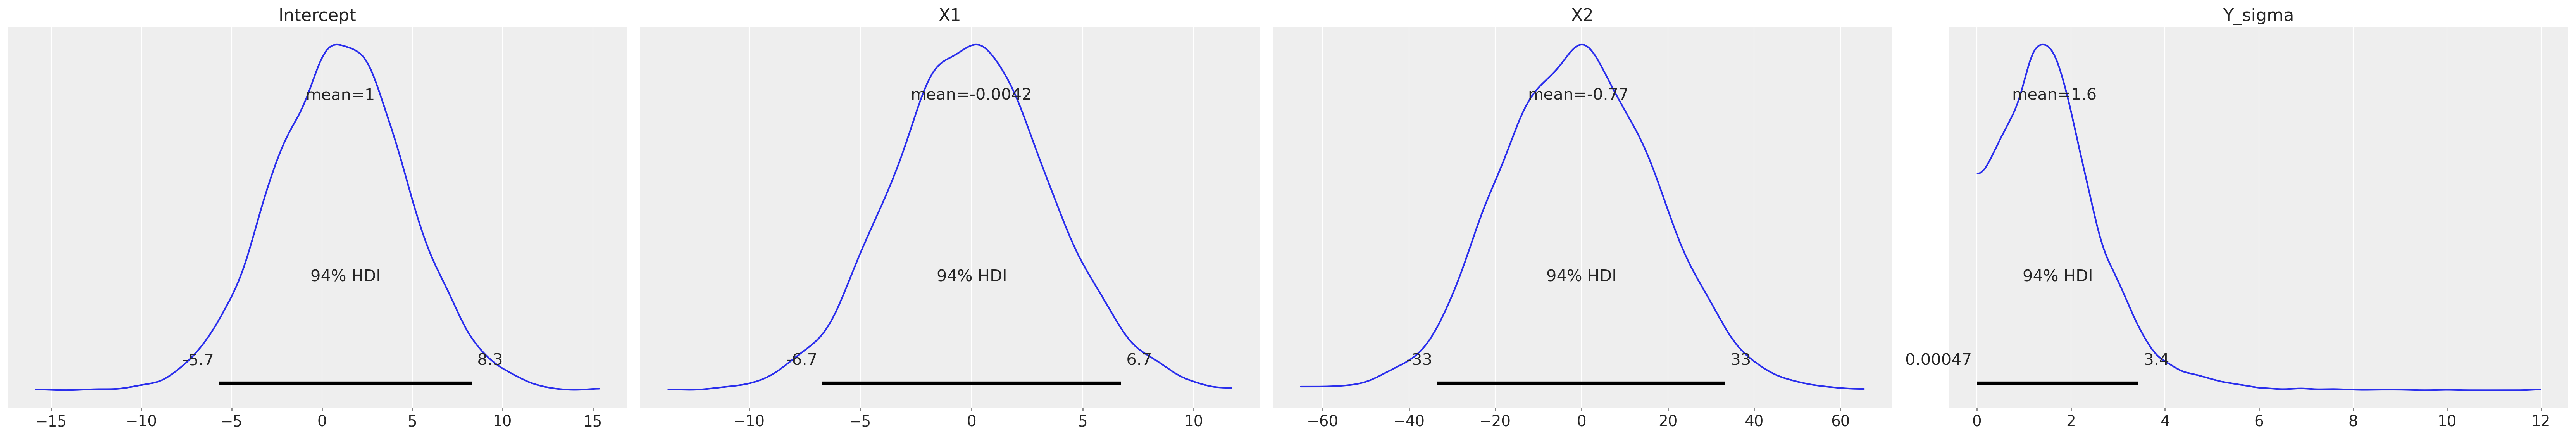

In [18]:
model.plot_priors()